# Simple Graph

Simple graph with 3 nodes and one conditional edge. 

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)



## [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

The State schema serves as the input schema for all Nodes and Edges in the graph.

`TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [32]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) 

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [33]:
def node_1(state):
    print("--Node 1--")
    return {"graph_state":state['graph_state'] +" I am"}

def node_2(state):
    print("--Node 2--")
    return {"graph_state":state['graph_state']+ " Happy!"}

def node_3(state):
    print("--Node 3--")
    return {'graph_state':state['graph_state']+ ' Sad!'}

## [Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [34]:
import random
from typing import Literal

def decide_mode(state) -> Literal["node_2", "node_3"]:

    user_input = state['graph_state']

    if random.random() < 0.5:

        return "node_2"
    
    return "node_3"

## Graph Construction 

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

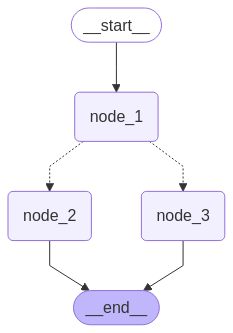

In [ ]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

#Building Graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

#Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mode)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

#Compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Graph Invoke

In [50]:
graph.invoke({"graph_state" : "Hi, this is Raahul"})

--Node 1--
--Node 2--


{'graph_state': 'Hi, this is Raahul I am Happy!'}

# Chain 

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [77]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"SO you said you were researching ocean mammals?", name='Model')]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Raahul"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name='Raahul'))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

SO you said you were researching ocean mammals?
================================ Human Message =================================
Name: Raahul

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Raahul

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [79]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [80]:
result

AIMessage(content='Certainly, Raahul! The best places to see orcas (killer whales) in the United States include:\n\n1. Puget Sound, Washington\n   - Known for its abundant orca populations, especially in the summer months.\n   - Popular spots include San Juan Islands and Bellingham.\n\n2. San Juan Islands, Washington\n   - A prime location for whale watching tours.\n   - Offers high chances of sightings due to the healthy orca communities.\n\n3. Vancouver Island, British Columbia (close proximity to the US)\n   - Tofino and Victoria are renowned for orca sightings.\n   - Many tour operators operate out of these ports during summer.\n\n4. Monterey Bay, California\n   - Offers opportunities to see orcas along with other marine life.\n   - Best during specific seasons, typically summer and fall.\n\nBest Time to Visit:\n- Summer months (June to September) are generally the most productive for orca sightings.\n- Always check with local tour operators for current sightings and best times.\n\

In [81]:
result.response_metadata

{'token_usage': {'completion_tokens': 245,
  'prompt_tokens': 71,
  'total_tokens': 316,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4.1-nano-2025-04-14',
 'system_fingerprint': 'fp_eede8f0d45',
 'id': 'chatcmpl-BS2bDy64xQDQrb0NERWnGnn68IQES',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [82]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [83]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name='Raahul')])

In [84]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_2W8kAEYMdgSQ91sDdPfOK8Ty',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [85]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    messages : list[AnyMessage]

## Reducers

Each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [88]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [89]:
from langgraph.graph import MessagesState

class MessageState(MessagesState):
    pass

In [90]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on CSK.", name="Raahul")
                   ]

new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='783bfd88-8cc4-4bed-b58f-6bf532d1f7bd'),
 HumanMessage(content="I'm looking for information on CSK.", additional_kwargs={}, response_metadata={}, name='Raahul', id='17fab6aa-011d-4797-ac0d-ecbf5cef106f'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='7346ddb5-ef47-4615-9597-01161b7f4f2c')]

## Our Garph

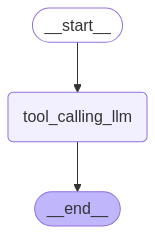

In [97]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

#Node
def tool_calling_llm(state: MessagesState):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [98]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [99]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_xnfQ1vR38K3QIcXdGCzSVDen)
 Call ID: call_xnfQ1vR38K3QIcXdGCzSVDen
  Args:
    a: 2
    b: 3


# Router

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed. 



In [112]:
from langchain_openai import ChatOpenAI

def multiply(a: float, b: float) -> float:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

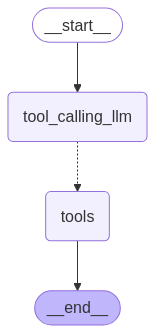

In [121]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [114]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, What is 1000 multiplly 0.5")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, What is 1000 multiplly 0.5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4V18MeY7x8DuQkg1C50PGbba)
 Call ID: call_4V18MeY7x8DuQkg1C50PGbba
  Args:
    a: 1000
    b: 0.5
================================= Tool Message =================================
Name: multiply

500.0


# Agent 

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [117]:
from langchain_openai import ChatOpenAI

def multiply(a:int, b:int)-> int:
    """Multiply two numbers a and b
    Args:
        a: first int
        b: second int
    """

    return a*b

def add(a: int, b: int)-> int:
    """Add two numbers a and b
    Args:
        a: first int
        b: second int
    """

    return a+b

def divide(a:int, b:int)-> float:
    """Divde two numbers a and b
    Args:
        a: first int
        b: second int
    """

    return a/b

tools = [add, multiply, divide]
llm = ChatOpenAI(model='gpt-4.1-nano')

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [126]:
from langgraph.graph import MessageGraph
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with erforming arithmetic on a set of inputs.")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

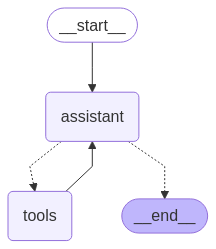

In [127]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessageState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

agent = builder.compile()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [128]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = agent.invoke({"messages": messages})

In [129]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_lMvFgf6lfhWjTpQB6vEzU9wj)
 Call ID: call_lMvFgf6lfhWjTpQB6vEzU9wj
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4ZaKmM0C1q1S6jUERSq8hVYI)
 Call ID: call_4ZaKmM0C1q1S6jUERSq8hVYI
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_o8F2CQKr2aHO169dOZJ18AHx)
 Call ID: call_o8F2CQKr2aHO169dOZJ18AHx
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

# Agent with Memory

Goals:
- Extend the agent by introducing memeory 

In [130]:
from langchain_openai import ChatOpenAI

def multiply(a:int, b:int)-> int:
    """ Multiply a and b
    
    Args:
        a: first int
        b: second int
        
    """

    return a*b

def add(a:int, b :int)-> int:
    """Add a and b
    
    Args:
        a: first int
        b: second int
    
    """

    return a+b

tools = [add, multiply]
llm = ChatOpenAI(model='gpt-4.1-nano')
llm_with_tools = llm.bind_tools(tools)

In [131]:
from langgraph.graph import MessageGraph
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content=f"You are a helpful assiatnt tasked with performing arithmetic on a set of inputs.")

def assistant(state=MessageGraph):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

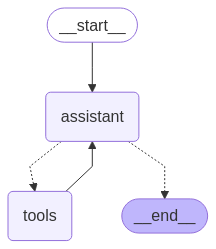

In [132]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

agent = builder.compile()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Memory

Agent without memory.

In [ ]:
messages = [HumanMessage(content=f"Add 3 and 7.")]
messages = agent.invoke({"messages":messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 7.
================================== Ai Message ==================================
Tool Calls:
  add (call_noYpc76V9CTgmdcOFDVY7PZo)
 Call ID: call_noYpc76V9CTgmdcOFDVY7PZo
  Args:
    a: 3
    b: 7
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The sum of 3 and 7 is 10.


Now, let's multiply by 2!

In [137]:
messages = [HumanMessage(content="Multiply the pervious answer by 2.")]
messages = agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply the pervious answer by 2.
================================== Ai Message ==================================

I need to know the previous answer before I can multiply it by 2. Could you please provide it?


LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [138]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

agent_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [139]:
# Specify a thread
Config = {"configurable":{"thread_id": "1"}}

messages = [HumanMessage(content=f"Add 3 and 7.")]

messages = agent_memory.invoke({"messages": messages}, Config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 7.
================================== Ai Message ==================================
Tool Calls:
  add (call_arsHoql6KqtrczuYooq9vACY)
 Call ID: call_arsHoql6KqtrczuYooq9vACY
  Args:
    a: 3
    b: 7
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The sum of 3 and 7 is 10.


Passing the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 7 is 10.`.

In [142]:
messages = [HumanMessage(content="Multiply the pervious answer by 2.")]
messages = agent_memory.invoke({"messages": messages}, Config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 7.
================================== Ai Message ==================================
Tool Calls:
  add (call_arsHoql6KqtrczuYooq9vACY)
 Call ID: call_arsHoql6KqtrczuYooq9vACY
  Args:
    a: 3
    b: 7
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================

The sum of 3 and 7 is 10.
================================ Human Message =================================

Multiply the pervious answer by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dFaKuw9pgsbkLYwSPEjEMkQ5)
 Call ID: call_dFaKuw9pgsbkLYwSPEjEMkQ5
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================

The